# Week 5 Image Features (Nightlights + Population)

**Goal:** create interpretable image-based features from yearly GeoTIFFs (nightlights + population), then run diagnostics and robustness checks.


In [1]:
import os, glob, re

DATA_PATH = r"C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images"

# If you're running this notebook on a different machine, update DATA_PATH.
# Fallbacks: try common relative folders used in this project/repo.
if not os.path.exists(DATA_PATH):
    candidates = [
        os.path.join(os.getcwd(), 'data', 'week5_images'),
        os.path.join(os.getcwd(), 'data', 'images'),
        os.path.join(os.getcwd(), 'STATS201_Week5_Images'),
        os.path.join(os.getcwd(), '..', 'data', 'week5_images'),
    ]
    for p in candidates:
        if os.path.exists(p):
            DATA_PATH = p
            break

tifs = sorted(glob.glob(os.path.join(DATA_PATH, "*.tif")))

print("Total tifs:", len(tifs))
print("First 10:")
for f in tifs[:10]:
    print(" -", os.path.basename(f))

morocco = [f for f in tifs if os.path.basename(f).startswith("Morocco_")]
print("\nMorocco tif count:", len(morocco))
print("Morocco years found:", sorted([int(re.findall(r"_(\d{4})", os.path.basename(f))[0]) for f in morocco]))

Total tifs: 10
First 10:
 - Morocco_2014.tif
 - Morocco_2015.tif
 - Morocco_2016.tif
 - Morocco_2017.tif
 - Morocco_2018.tif
 - Morocco_2019.tif
 - Morocco_2020.tif
 - Morocco_2021.tif
 - Morocco_2022.tif
 - Morocco_2023.tif

Morocco tif count: 10
Morocco years found: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [2]:
COUNTRIES = ["Morocco"]
YEARS = list(range(2014, 2024))

In [3]:
# Sanity checks
print('Countries:', COUNTRIES)
print('Years:', YEARS[0], '->', YEARS[-1], '(n=', len(YEARS), ')')


Countries: ['Morocco']
Years: 2014 -> 2023 (n= 10 )


In [4]:
# Core scientific stack
import numpy as np
import pandas as pd

# Geo / raster
import rasterio
import geopandas as gpd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


In [5]:
def read_band(ds, b):
    arr = ds.read(b, masked=True).astype("float32")
    if hasattr(arr, "filled"):
        arr = arr.filled(np.nan)
    return arr

def load_image(country, year):
    fp = os.path.join(DATA_PATH, f"{country}_{year}.tif")
    if not os.path.exists(fp):
        return None, "missing"

    try:
        with rasterio.open(fp) as ds:
            nl = read_band(ds, 1)
            pop = read_band(ds, 2)
            popn = read_band(ds, 3)

        valid = np.isfinite(nl) & np.isfinite(pop) & np.isfinite(popn)
        nl[~valid] = np.nan
        pop[~valid] = np.nan
        popn[~valid] = np.nan

        return {
            "path": fp,
            "country": country,
            "year": year,
            "nightlights": nl,
            "pop": pop,
            "pop_norm": popn,
            "shape": nl.shape
        }, None
    except Exception as e:
        return None, str(e)

In [6]:
images = {c: {} for c in COUNTRIES}
errors = []

for c in COUNTRIES:
    for y in YEARS:
        data, err = load_image(c, y)
        if err is None:
            images[c][y] = data
        else:
            errors.append((c, y, err))

print("Loaded:", sum(len(images[c]) for c in COUNTRIES))
print("Errors (first 10):", errors[:10])
print("Example shape:", next(iter(images["Morocco"].values()))["shape"])

Loaded: 10
Errors (first 10): []
Example shape: (1839, 2712)


In [7]:
def band_stats(img, name):
    a = img[name]
    v = a[np.isfinite(a)]
    print(name, "min", float(np.min(v)), "p50", float(np.percentile(v,50)),
          "p99", float(np.percentile(v,99)), "max", float(np.max(v)))

sample = images["Morocco"][2020]
band_stats(sample, "nightlights")
band_stats(sample, "pop")
band_stats(sample, "pop_norm")

nightlights min 0.20499999821186066 p50 0.3141666650772095 p99 8.665833473205566 max 350.2458190917969
pop min 0.0 p50 0.0 p99 736.0 max 87508.0
pop_norm min 0.0 p50 0.0 p99 1.0 max 1.0


In [8]:
OUTPUT_DIR = os.path.join(os.path.dirname(DATA_PATH), "week5_outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def stack_country(images_by_year, band):
    yrs = sorted(images_by_year.keys())
    arrs = [images_by_year[y][band] for y in yrs]
    stack = np.stack(arrs, axis=0)  # (T, H, W)
    mean_img = np.nanmean(stack, axis=0)
    std_img  = np.nanstd(stack, axis=0)
    return yrs, mean_img, std_img

yrs, nl_mean, nl_std = stack_country(images["Morocco"], "nightlights")
_, pop_mean, pop_std = stack_country(images["Morocco"], "pop")

print("Years stacked:", yrs[0], "->", yrs[-1], "T =", len(yrs))
print("Nightlights mean/std shapes:", nl_mean.shape, nl_std.shape)

C:\Users\BOUCHRA\AppData\Local\Temp\ipykernel_29872\1989258282.py:11: RuntimeWarning: Mean of empty slice
  mean_img = np.nanmean(stack, axis=0)
C:\Users\BOUCHRA\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Years stacked: 2014 -> 2023 T = 10
Nightlights mean/std shapes: (1839, 2712) (1839, 2712)


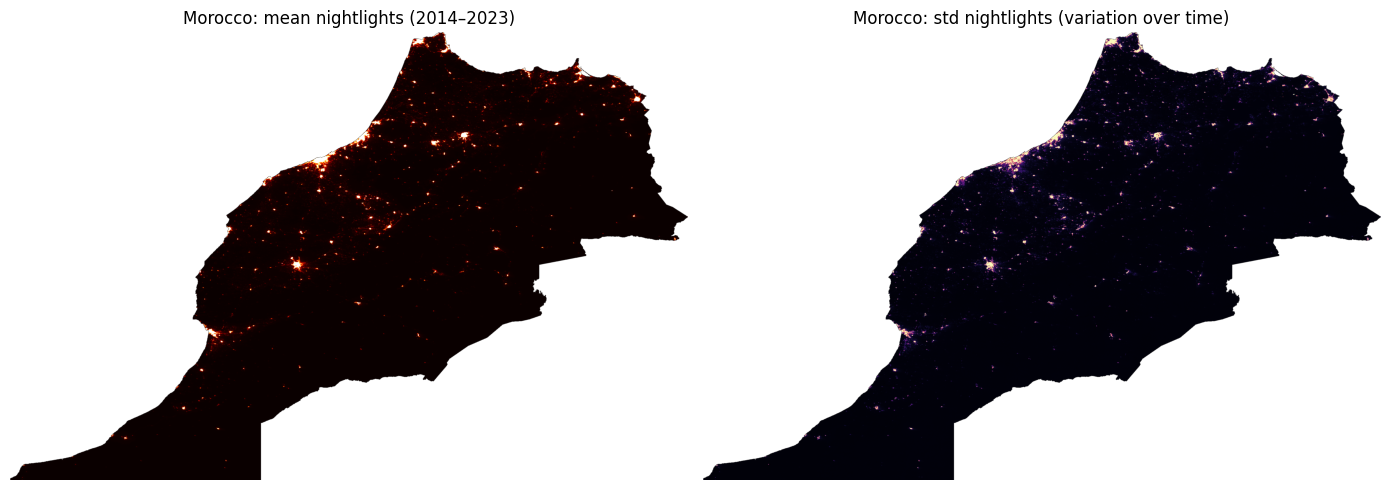

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_mean_std_nightlights.png


In [9]:
def clip_img(a, p=99.5):
    v = a[np.isfinite(a)]
    if v.size == 0:
        return a, (0, 1)
    hi = np.percentile(v, p)
    return np.clip(a, 0, hi), (0, hi)

nl_mean_clip, (vmin1, vmax1) = clip_img(nl_mean, 99.5)
nl_std_clip,  (vmin2, vmax2) = clip_img(nl_std,  99.5)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].imshow(nl_mean_clip, cmap="hot", aspect="auto")
ax[0].set_title("Morocco: mean nightlights (2014–2023)")
ax[0].axis("off")

ax[1].imshow(nl_std_clip, cmap="magma", aspect="auto")
ax[1].set_title("Morocco: std nightlights (variation over time)")
ax[1].axis("off")

plt.tight_layout()
out = os.path.join(OUTPUT_DIR, "Morocco_mean_std_nightlights.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out)

In [10]:
def yearly_mass_series(country, lit_percentile=90):
    rows = []
    for y, img in sorted(images[country].items()):
        nl = img["nightlights"]
        pop = img["pop"]

        valid = np.isfinite(nl)
        nl_v = nl[valid]

        # Robust lit threshold: percentile of positive values
        pos = nl_v[nl_v > 0]
        if pos.size == 0:
            lit_thr = np.nan
            lit = np.zeros_like(nl, dtype=bool)
        else:
            lit_thr = float(np.percentile(pos, lit_percentile))
            lit = valid & (nl >= lit_thr)

        # Mass on lit pixels only
        light_mass = float(np.nansum(nl[lit]))

        # Mean over ALL pixels (including dark)
        mean_all = float(np.nanmean(nl_v))

        # Mean over LIT pixels only
        mean_lit = float(np.nanmean(nl[lit])) if np.any(lit) else np.nan

        # Lit fraction (how much of country is "bright")
        lit_frac = float(np.sum(lit) / np.sum(valid))

        # Size correction: per pixel over ALL pixels
        light_mass_per_pixel_all = light_mass / max(int(np.sum(valid)), 1)

        # Population mass + per-pop light
        pop_v = pop[np.isfinite(pop)]
        pop_mass = float(np.nansum(pop_v))
        light_per_pop = light_mass / (pop_mass + 1e-8)

        rows.append({
            "country": country,
            "year": y,
            "area_pixels": int(np.sum(valid)),
            "lit_threshold": lit_thr,
            "lit_fraction": lit_frac,
            "light_mass_lit": light_mass,
            "mean_light_all": mean_all,
            "mean_light_lit": mean_lit,
            "light_mass_per_pixel_all": light_mass_per_pixel_all,
            "pop_mass": pop_mass,
            "light_per_pop": light_per_pop
        })
    return pd.DataFrame(rows)

df_m = yearly_mass_series("Morocco", lit_percentile=90)
df_m

,country,year,area_pixels,lit_threshold,lit_fraction,light_mass_lit,mean_light_all,mean_light_lit,light_mass_per_pixel_all,pop_mass,light_per_pop
0,Morocco,2014,1961436,0.361460,0.100000,685250.8750,0.480643,3.493611,0.349362,112780912.0,0.006076
1,Morocco,2015,1961436,0.367536,0.100000,729496.3750,0.497823,3.719188,0.371920,113931104.0,0.006403
2,Morocco,2016,1961436,0.377602,0.100000,768401.8125,0.500204,3.917539,0.391755,115117016.0,0.006675
3,Morocco,2017,1961443,0.590760,0.100000,843341.3125,0.707689,4.299581,0.429960,116198296.0,0.007258
4,Morocco,2018,1961449,0.559167,0.100207,836751.5625,0.682181,4.257173,0.426599,117259896.0,0.007136
5,Morocco,2019,1961453,0.567500,0.100108,902923.4375,0.692248,4.598377,0.460334,120357856.0,0.007502
6,Morocco,2020,1961453,0.650833,0.100050,900426.8125,0.763582,4.588303,0.459061,121532896.0,0.007409
7,Morocco,2021,1961454,0.705833,0.100111,895807.9375,0.791764,4.562000,0.456706,122699896.0,0.007301
8,Morocco,2022,1961457,0.725000,0.100054,925862.0000,0.814945,4.717744,0.472028,123290824.0,0.007510
9,Morocco,2023,1961457,0.802500,0.100124,967966.8125,0.885020,4.928824,0.493494,124395320.0,0.007781


In [11]:
BIN_NAMES = ["very_low", "low", "medium", "high", "very_high"]

def pop_bins_and_light_share(country, year, use_norm=True):
    img = images[country][year]
    nl = img["nightlights"]
    pop = img["pop_norm"] if use_norm else img["pop"]

    valid = np.isfinite(nl) & np.isfinite(pop)

    p = pop[valid]
    qs = np.quantile(p, [0.2, 0.4, 0.6, 0.8])  # 5 equal-frequency bins by pixels

    b = np.digitize(pop, qs, right=True)  # 0..4
    b[~valid] = -1

    nl_pos = nl.copy()
    nl_pos[~valid] = np.nan
    nl_pos[nl_pos < 0] = np.nan

    total_light = float(np.nansum(nl_pos))

    rows = []
    for k, name in enumerate(BIN_NAMES):
        m = (b == k)
        light_k = float(np.nansum(nl_pos[m]))
        pix_k = int(np.sum(m))
        rows.append({
            "country": country,
            "year": year,
            "bin": name,
            "pixels": pix_k,
            "light_mass": light_k,
            "light_share": light_k / (total_light + 1e-8)
        })
    return pd.DataFrame(rows)

df_bins = pd.concat(
    [pop_bins_and_light_share("Morocco", y, use_norm=True) for y in YEARS if y in images["Morocco"]],
    ignore_index=True
)

df_bins.head(10)

,country,year,bin,pixels,light_mass,light_share
0,Morocco,2014,very_low,1415183,207543.06250,0.220146
1,Morocco,2014,low,0,0.00000,0.000000
2,Morocco,2014,medium,0,0.00000,0.000000
3,Morocco,2014,high,546253,735207.50000,0.779854
4,Morocco,2014,very_high,0,0.00000,0.000000
5,Morocco,2015,very_low,1422757,203774.21875,0.208689
6,Morocco,2015,low,0,0.00000,0.000000
7,Morocco,2015,medium,0,0.00000,0.000000
8,Morocco,2015,high,538679,772673.12500,0.791310
9,Morocco,2015,very_high,0,0.00000,0.000000


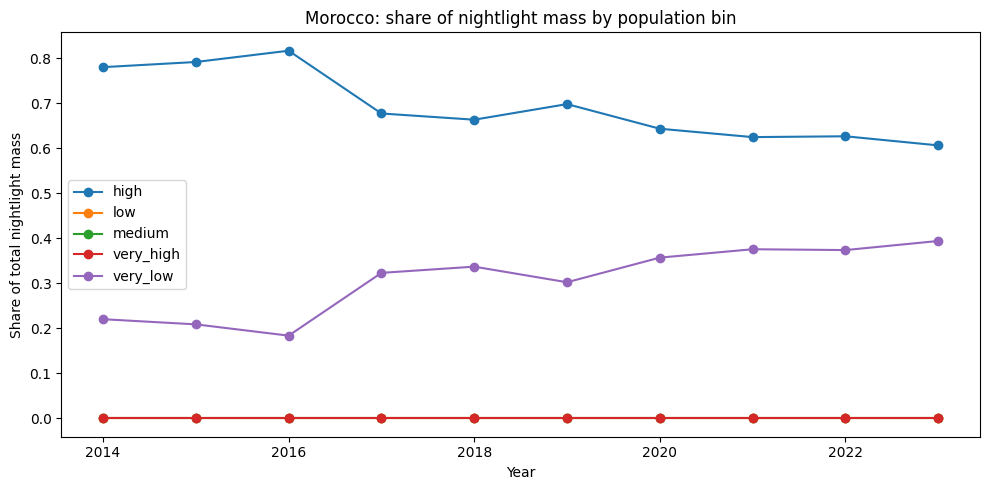

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_light_share_by_pop_bin.png


In [12]:
pivot = df_bins.pivot_table(index="year", columns="bin", values="light_share", aggfunc="mean").sort_index()

plt.figure(figsize=(10, 5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=col)

plt.title("Morocco: share of nightlight mass by population bin")
plt.xlabel("Year")
plt.ylabel("Share of total nightlight mass")
plt.legend()
plt.tight_layout()

out = os.path.join(OUTPUT_DIR, "Morocco_light_share_by_pop_bin.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out)

In [13]:
# Save summary tables for the report / GitHub
df_m.to_csv(os.path.join(OUTPUT_DIR, 'Morocco_yearly_mass_series.csv'), index=False)
df_bins.to_csv(os.path.join(OUTPUT_DIR, 'Morocco_popbin_lightshare_long.csv'), index=False)
print('Saved CSVs to:', OUTPUT_DIR)


Saved CSVs to: <week5_outputs>


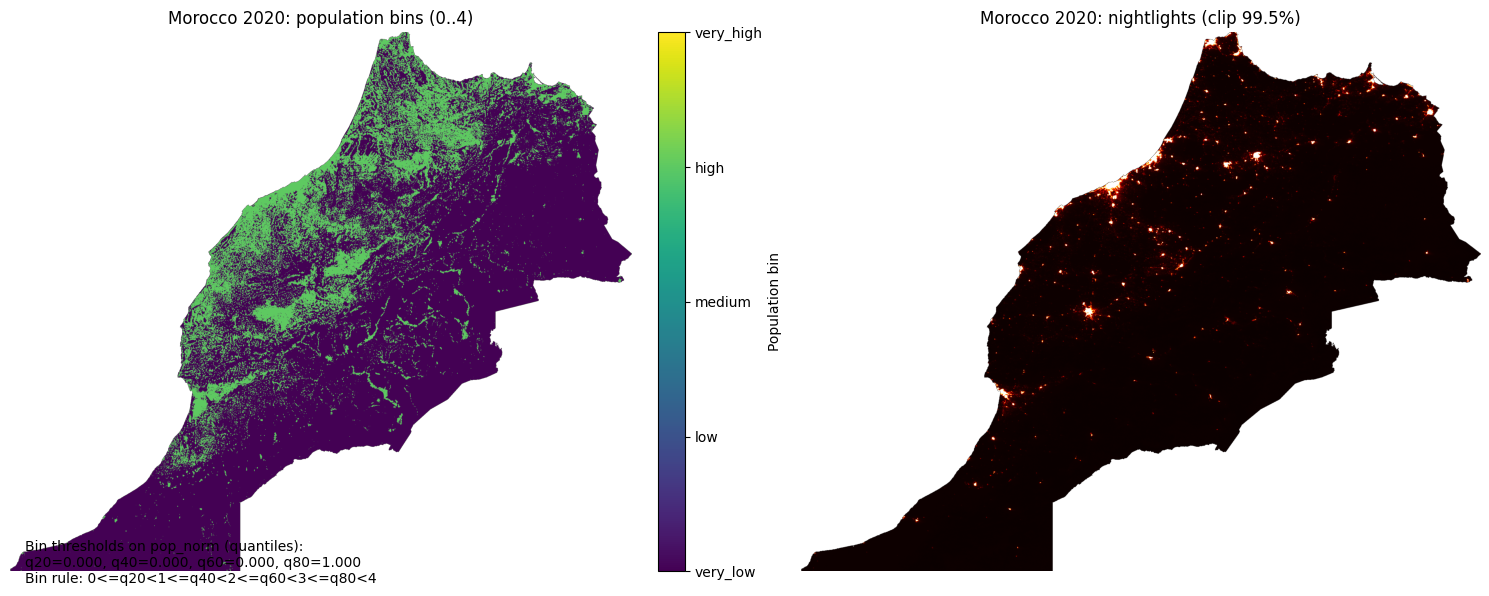

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_pop_bins_map_2020_labeled.png
Thresholds (pop_norm): [0. 0. 0. 1.]


In [14]:
BIN_NAMES = ["very_low", "low", "medium", "high", "very_high"]

def compute_pop_bins(pop, valid):
    p = pop[valid]
    qs = np.quantile(p, [0.2, 0.4, 0.6, 0.8])
    b = np.digitize(pop, qs, right=True).astype("float32")  # 0..4
    b[~valid] = np.nan
    return b, qs

def clip_img(a, p=99.5):
    v = a[np.isfinite(a)]
    if v.size == 0:
        return a, (0, 1)
    hi = np.percentile(v, p)
    return np.clip(a, 0, hi), (0, hi)

country = "Morocco"
year_show = 2020

img = images[country][year_show]
nl = img["nightlights"]
pop = img["pop_norm"]  # bins computed on pop_norm

valid = np.isfinite(nl) & np.isfinite(pop)
bmap, qs = compute_pop_bins(pop, valid)

nl_show, _ = clip_img(nl, 99.5)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

im0 = ax[0].imshow(bmap, cmap="viridis", aspect="auto", vmin=0, vmax=4)
ax[0].set_title(f"{country} {year_show}: population bins (0..4)")
ax[0].axis("off")

cbar = plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, ticks=[0,1,2,3,4])
cbar.ax.set_yticklabels(BIN_NAMES)
cbar.set_label("Population bin")

ax[1].imshow(nl_show, cmap="hot", aspect="auto")
ax[1].set_title(f"{country} {year_show}: nightlights (clip 99.5%)")
ax[1].axis("off")

txt = (
    "Bin thresholds on pop_norm (quantiles):\n"
    f"q20={qs[0]:.3f}, q40={qs[1]:.3f}, q60={qs[2]:.3f}, q80={qs[3]:.3f}\n"
    "Bin rule: 0<=q20<1<=q40<2<=q60<3<=q80<4"
)
fig.text(0.02, 0.02, txt, fontsize=10)

plt.tight_layout()
out = os.path.join(OUTPUT_DIR, f"{country}_pop_bins_map_{year_show}_labeled.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out)
print("Thresholds (pop_norm):", qs)

In [15]:
def pop_bins_and_light_share(country, year, use_norm=True):
    img = images[country][year]
    nl = img["nightlights"]
    pop = img["pop_norm"] if use_norm else img["pop"]

    valid = np.isfinite(nl) & np.isfinite(pop)
    p = pop[valid]
    qs = np.quantile(p, [0.2, 0.4, 0.6, 0.8])

    b = np.digitize(pop, qs, right=True)  # 0..4
    b[~valid] = -1

    nl_pos = nl.copy()
    nl_pos[~valid] = np.nan
    nl_pos[nl_pos < 0] = np.nan

    total_light = float(np.nansum(nl_pos))

    rows = []
    for k, name in enumerate(BIN_NAMES):
        m = (b == k)
        light_k = float(np.nansum(nl_pos[m]))
        rows.append({
            "country": country,
            "year": year,
            "bin": name,
            "light_mass": light_k,
            "light_share": light_k / (total_light + 1e-8)
        })
    return pd.DataFrame(rows)

df_bins = pd.concat(
    [pop_bins_and_light_share("Morocco", y, use_norm=True)
     for y in YEARS if y in images["Morocco"]],
    ignore_index=True
)

# clean summary table (average across years)
summary = (df_bins.groupby("bin")["light_share"]
           .agg(["mean", "min", "max"])
           .sort_values("mean", ascending=False))

summary

,mean,min,max
bin,,,
high,0.692549,0.606133,0.816350
very_low,0.307451,0.183650,0.393867
low,0.000000,0.000000,0.000000
medium,0.000000,0.000000,0.000000
very_high,0.000000,0.000000,0.000000


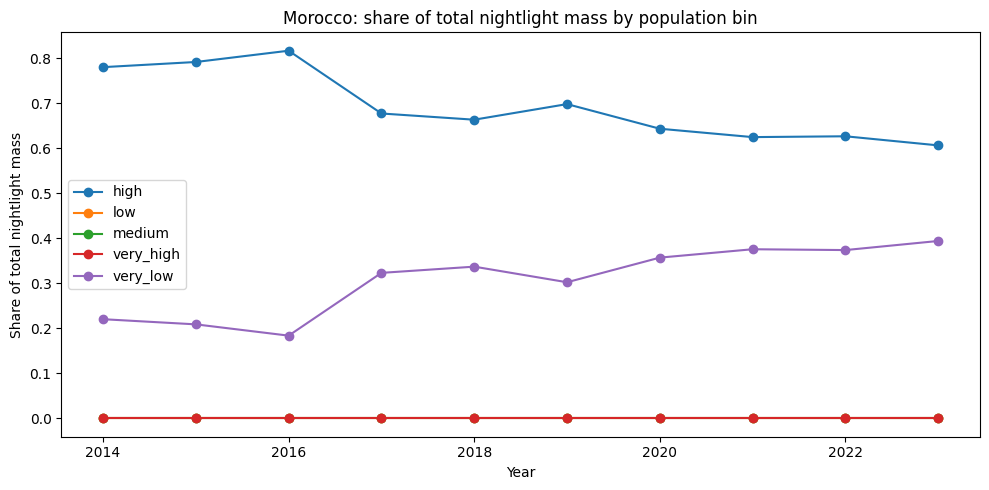

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_light_share_by_pop_bin.png


In [16]:
pivot = df_bins.pivot_table(index="year", columns="bin", values="light_share").sort_index()

plt.figure(figsize=(10,5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=col)

plt.title("Morocco: share of total nightlight mass by population bin")
plt.xlabel("Year")
plt.ylabel("Share of total nightlight mass")
plt.legend()
plt.tight_layout()

out = os.path.join(OUTPUT_DIR, "Morocco_light_share_by_pop_bin.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out)

Robustness Check

In [17]:
## Change the binning method: quantiles → fixed thresholds on pop_norm
def fixed_bins_and_light_share(country, year):
    img = images[country][year]
    nl = img["nightlights"]
    pop = img["pop_norm"]

    valid = np.isfinite(nl) & np.isfinite(pop)

    edges = np.array([0.2, 0.4, 0.6, 0.8])
    b = np.digitize(pop, edges, right=False)  # 0..4
    b[~valid] = -1

    nl_pos = nl.copy()
    nl_pos[~valid] = np.nan
    nl_pos[nl_pos < 0] = np.nan

    total_light = float(np.nansum(nl_pos))

    rows = []
    for k, name in enumerate(BIN_NAMES):
        m = (b == k)
        light_k = float(np.nansum(nl_pos[m]))
        rows.append({
            "country": country,
            "year": year,
            "bin": name,
            "light_share": light_k / (total_light + 1e-8)
        })
    return pd.DataFrame(rows)

df_bins_fixed = pd.concat(
    [fixed_bins_and_light_share("Morocco", y) for y in YEARS if y in images["Morocco"]],
    ignore_index=True
)

comp = df_bins.groupby("bin")["light_share"].mean().to_frame("quantile_bins")
comp["fixed_bins"] = df_bins_fixed.groupby("bin")["light_share"].mean()
comp["abs_diff"] = (comp["quantile_bins"] - comp["fixed_bins"]).abs()
comp.sort_values("abs_diff", ascending=False)

,quantile_bins,fixed_bins,abs_diff
bin,,,
high,0.692549,0.000000,0.692549
very_high,0.000000,0.692549,0.692549
low,0.000000,0.000000,0.000000
medium,0.000000,0.000000,0.000000
very_low,0.307451,0.307451,0.000000


In [18]:
## Change the “light” definition: top 10% lit vs top 5% lit
def light_mass_lit(country, lit_percentile):
    rows = []
    for y, img in sorted(images[country].items()):
        nl = img["nightlights"]
        valid = np.isfinite(nl)
        pos = nl[valid & (nl > 0)]
        if pos.size == 0:
            continue
        thr = float(np.percentile(pos, lit_percentile))
        lit = valid & (nl >= thr)
        rows.append({
            "year": y,
            "lit_percentile": lit_percentile,
            "lit_threshold": thr,
            "lit_fraction": float(np.sum(lit) / np.sum(valid)),
            "light_mass_lit": float(np.nansum(nl[lit]))
        })
    return pd.DataFrame(rows)

df_lit90 = light_mass_lit("Morocco", 90)
df_lit95 = light_mass_lit("Morocco", 95)

df_lit = pd.merge(df_lit90, df_lit95, on="year", suffixes=("_p90", "_p95"))
df_lit[["year","light_mass_lit_p90","light_mass_lit_p95","lit_threshold_p90","lit_threshold_p95"]].head()

,year,light_mass_lit_p90,light_mass_lit_p95,lit_threshold_p90,lit_threshold_p95
0,2014,685250.8750,637954.4375,0.361460,0.679456
1,2015,729496.3750,680563.7500,0.367536,0.711412
2,2016,768401.8125,717318.3750,0.377602,0.753266
3,2017,843341.3125,770193.1250,0.590760,0.997842
4,2018,836751.5625,766655.8125,0.559167,0.962500


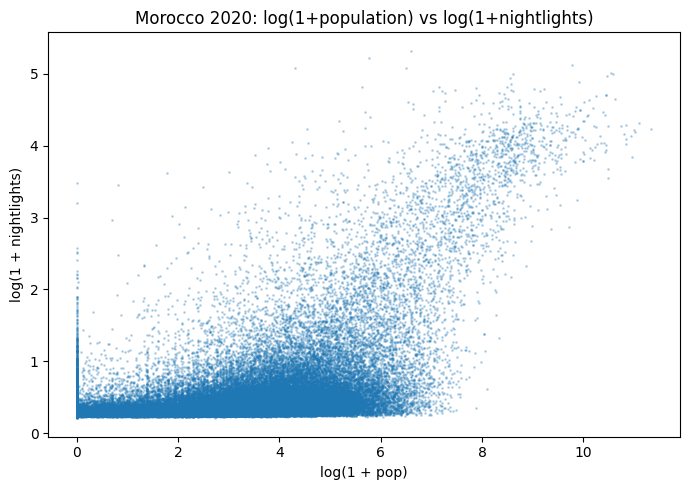

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_2020_scatter_log_pop_vs_log_nl.png


In [19]:
def scatter_nl_pop(country, year, sample_n=200000, seed=0):
    img = images[country][year]
    nl = img["nightlights"]
    pop = img["pop"]

    valid = np.isfinite(nl) & np.isfinite(pop) & (nl >= 0) & (pop >= 0)
    nl_v = nl[valid].ravel()
    pop_v = pop[valid].ravel()

    n = nl_v.size
    if n > sample_n:
        rng = np.random.default_rng(seed)
        idx = rng.choice(n, size=sample_n, replace=False)
        nl_v = nl_v[idx]
        pop_v = pop_v[idx]

    # log1p to handle zeros
    x = np.log1p(pop_v)
    y = np.log1p(nl_v)

    plt.figure(figsize=(7,5))
    plt.scatter(x, y, s=1, alpha=0.25)
    plt.title(f"{country} {year}: log(1+population) vs log(1+nightlights)")
    plt.xlabel("log(1 + pop)")
    plt.ylabel("log(1 + nightlights)")
    plt.tight_layout()

    out = os.path.join(OUTPUT_DIR, f"{country}_{year}_scatter_log_pop_vs_log_nl.png")
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out)

scatter_nl_pop("Morocco", 2020)

In [20]:
def regional_grid_stats(country, year, grid=80, lit_p=90):
    img = images[country][year]
    nl = img["nightlights"]
    pop = img["pop"]

    valid = np.isfinite(nl) & np.isfinite(pop) & (nl >= 0) & (pop >= 0)
    h, w = nl.shape

    pos = nl[valid & (nl > 0)]
    lit_thr = float(np.percentile(pos, lit_p)) if pos.size else 0.0

    rows = []
    rid = 0
    for r0 in range(0, h, grid):
        for c0 in range(0, w, grid):
            r1, c1 = min(r0+grid, h), min(c0+grid, w)
            m = valid[r0:r1, c0:c1]
            if np.sum(m) < 50:
                continue

            nl_blk = nl[r0:r1, c0:c1][m]
            pop_blk = pop[r0:r1, c0:c1][m]

            # lit pixels within block
            lit = nl_blk >= lit_thr
            lit_frac = float(np.mean(lit))

            rows.append({
                "country": country,
                "year": year,
                "region_id": rid,
                "row": r0 // grid,
                "col": c0 // grid,
                "n_pixels": int(np.sum(m)),
                "mean_nl": float(np.mean(nl_blk)),
                "std_nl": float(np.std(nl_blk)),
                "mean_pop": float(np.mean(pop_blk)),
                "std_pop": float(np.std(pop_blk)),
                "corr_nl_pop": float(np.corrcoef(nl_blk, pop_blk)[0,1]) if nl_blk.size > 10 else np.nan,
                "lit_frac": lit_frac
            })
            rid += 1

    return pd.DataFrame(rows), lit_thr

df_reg, lit_thr = regional_grid_stats("Morocco", 2023, grid=80, lit_p=90)
print("Regions:", len(df_reg), "lit_thr:", lit_thr)
df_reg.head()

Regions: 351 lit_thr: 0.8025000095367432


,country,year,region_id,row,col,n_pixels,mean_nl,std_nl,mean_pop,std_pop,corr_nl_pop,lit_frac
0,Morocco,2023,0,0,20,4089,14.476233,28.415426,948.045044,4748.530273,0.627186,0.865004
1,Morocco,2023,1,0,21,4943,6.690072,18.925831,465.423431,2310.853516,0.385059,0.881246
2,Morocco,2023,2,1,19,1648,2.150107,6.545299,137.339218,496.190399,0.797218,0.351335
3,Morocco,2023,3,1,20,6400,0.712719,1.299472,46.264053,91.977333,0.232259,0.143437
4,Morocco,2023,4,1,21,6400,1.011959,2.724918,79.657860,468.762787,0.687888,0.181406


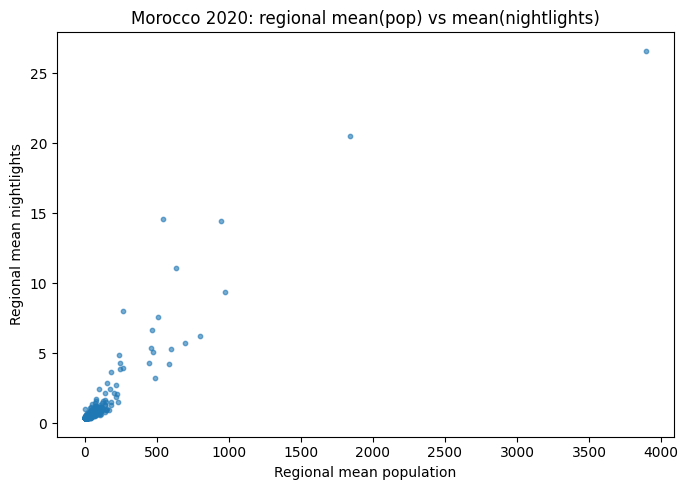

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_2020_regional_mean_pop_vs_mean_nl.png


In [21]:
plt.figure(figsize=(7,5))
plt.scatter(df_reg["mean_pop"], df_reg["mean_nl"], s=10, alpha=0.6)
plt.title("Morocco 2020: regional mean(pop) vs mean(nightlights)")
plt.xlabel("Regional mean population")
plt.ylabel("Regional mean nightlights")
plt.tight_layout()

out = os.path.join(OUTPUT_DIR, "Morocco_2020_regional_mean_pop_vs_mean_nl.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out)

In [22]:
def label_region(row):
    # simple interpretable categories
    if row["mean_pop"] < df_reg["mean_pop"].quantile(0.2) and row["mean_nl"] < df_reg["mean_nl"].quantile(0.2):
        return "empty_or_rural"
    if row["mean_pop"] > df_reg["mean_pop"].quantile(0.8) and row["mean_nl"] > df_reg["mean_nl"].quantile(0.8):
        return "urban_core"
    if row["mean_pop"] > df_reg["mean_pop"].quantile(0.8) and row["mean_nl"] < df_reg["mean_nl"].quantile(0.5):
        return "dense_dim"   # people but not bright (bias / under-electrified / mismatch)
    if row["mean_pop"] < df_reg["mean_pop"].quantile(0.5) and row["mean_nl"] > df_reg["mean_nl"].quantile(0.8):
        return "bright_sparse"  # ports, roads, industry, gas flares (potential failure case)
    return "mixed"

df_reg["region_type"] = df_reg.apply(label_region, axis=1)
df_reg["region_type"].value_counts()

region_type
mixed             264
urban_core         50
empty_or_rural     36
bright_sparse       1
Name: count, dtype: int64

In [23]:
##Build region polygons in real coordinates
from shapely.geometry import box

def add_region_type(df):
    q_pop20 = df["mean_pop"].quantile(0.2)
    q_pop50 = df["mean_pop"].quantile(0.5)
    q_pop80 = df["mean_pop"].quantile(0.8)
    q_nl20  = df["mean_nl"].quantile(0.2)
    q_nl50  = df["mean_nl"].quantile(0.5)
    q_nl80  = df["mean_nl"].quantile(0.8)

    def label(row):
        if row["mean_pop"] < q_pop20 and row["mean_nl"] < q_nl20:
            return "empty_or_rural"
        if row["mean_pop"] > q_pop80 and row["mean_nl"] > q_nl80:
            return "urban_core"
        if row["mean_pop"] > q_pop80 and row["mean_nl"] < q_nl50:
            return "dense_dim"
        if row["mean_pop"] < q_pop50 and row["mean_nl"] > q_nl80:
            return "bright_sparse"
        return "mixed"

    df = df.copy()
    df["region_type"] = df.apply(label, axis=1)
    return df

def regions_to_geodataframe(country, year, df_reg, grid=80):
    # open a tif to get transform/crs/shape
    fp = images[country][year]["path"]
    with rasterio.open(fp) as ds:
        transform = ds.transform
        crs = ds.crs
        height, width = ds.height, ds.width

    # convert each (row, col) region block to a polygon in map coordinates
    geoms = []
    for _, r in df_reg.iterrows():
        r0 = int(r["row"]) * grid
        c0 = int(r["col"]) * grid
        r1 = min(r0 + grid, height)
        c1 = min(c0 + grid, width)

        # pixel -> map coords (left, top) and (right, bottom)
        x_left, y_top = rasterio.transform.xy(transform, r0, c0, offset="ul")
        x_right, y_bottom = rasterio.transform.xy(transform, r1, c1, offset="lr")

        geoms.append(box(x_left, y_bottom, x_right, y_top))

    gdf = gpd.GeoDataFrame(df_reg.reset_index(drop=True).copy(), geometry=geoms, crs=crs)
    return gdf

country = "Morocco"
year_map = 2023
grid = 80

# df_reg must be the output of regional_grid_stats(country, year_map, grid=grid, ...)
df_reg_2023 = add_region_type(df_reg.copy())
gdf_regions_2023 = regions_to_geodataframe(country, year_map, df_reg_2023, grid=grid)

print(gdf_regions_2023["region_type"].value_counts())
gdf_regions_2023.head()

region_type
mixed             264
urban_core         50
empty_or_rural     36
bright_sparse       1
Name: count, dtype: int64


,country,year,region_id,row,col,n_pixels,mean_nl,std_nl,mean_pop,std_pop,corr_nl_pop,lit_frac,region_type,geometry
0,Morocco,2023,0,0,20,4089,14.476233,28.415426,948.045044,4748.530273,0.627186,0.865004,urban_core,"POLYGON ((-5.62345 35.55981, -5.62345 35.92363..."
1,Morocco,2023,1,0,21,4943,6.690072,18.925831,465.423431,2310.853516,0.385059,0.881246,urban_core,"POLYGON ((-5.26413 35.55981, -5.26413 35.92363..."
2,Morocco,2023,2,1,19,1648,2.150107,6.545299,137.339218,496.190399,0.797218,0.351335,urban_core,"POLYGON ((-5.98278 35.20048, -5.98278 35.5643,..."
3,Morocco,2023,3,1,20,6400,0.712719,1.299472,46.264053,91.977333,0.232259,0.143437,mixed,"POLYGON ((-5.62345 35.20048, -5.62345 35.5643,..."
4,Morocco,2023,4,1,21,6400,1.011959,2.724918,79.657860,468.762787,0.687888,0.181406,mixed,"POLYGON ((-5.26413 35.20048, -5.26413 35.5643,..."


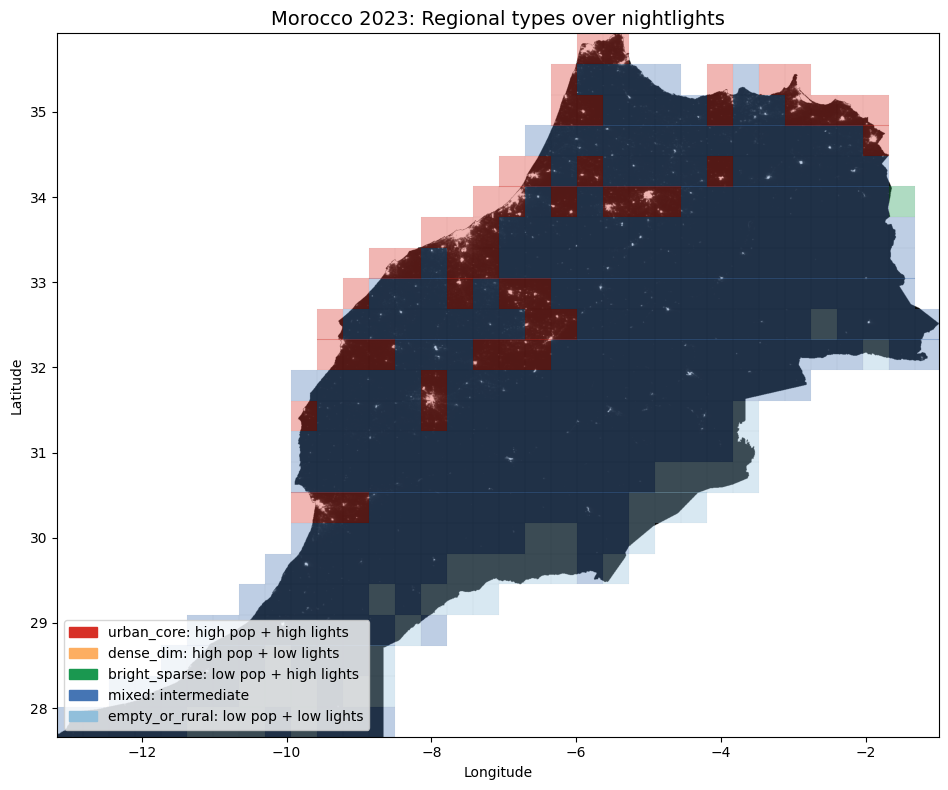

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_2023_region_types_over_nightlights.png


In [24]:
import matplotlib.patches as mpatches
def clip_for_display(a, p=99.7):
    v = a[np.isfinite(a)]
    if v.size == 0:
        return a, (0, 1)
    hi = np.percentile(v, p)
    return np.clip(a, 0, hi), (0, hi)

# Background nightlights image
nl = images[country][year_map]["nightlights"]
nl_show, (_, nl_hi) = clip_for_display(nl, p=99.7)

# Extent in map coordinates (so imshow is georeferenced)
with rasterio.open(images[country][year_map]["path"]) as ds:
    left, bottom, right, top = ds.bounds
    extent = (left, right, bottom, top)

# Color scheme (GIS-friendly, interpretable)
colors = {
    "urban_core": "#d73027",      # red
    "mixed": "#4575b4",           # blue
    "empty_or_rural": "#91bfdb",  # light blue
    "dense_dim": "#fdae61",       # orange (people but dim)
    "bright_sparse": "#1a9850"    # green (bright but sparse)
}

fig, ax = plt.subplots(figsize=(10, 8))

# Nightlights background
ax.imshow(nl_show, extent=extent, cmap="gray", origin="upper", alpha=0.95)

# Region polygons overlay
for t, sub in gdf_regions_2023.groupby("region_type"):
    sub.plot(ax=ax, facecolor=colors.get(t, "#cccccc"), edgecolor="none", alpha=0.35)

# Outline regions lightly for readability (optional)
gdf_regions_2023.boundary.plot(ax=ax, color="black", linewidth=0.05, alpha=0.25)

# Titles + subtitle
ax.set_title(f"{country} {year_map}: Regional types over nightlights", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Legend with explanations
legend_items = [
    mpatches.Patch(color=colors["urban_core"], label="urban_core: high pop + high lights"),
    mpatches.Patch(color=colors["dense_dim"], label="dense_dim: high pop + low lights"),
    mpatches.Patch(color=colors["bright_sparse"], label="bright_sparse: low pop + high lights"),
    mpatches.Patch(color=colors["mixed"], label="mixed: intermediate"),
    mpatches.Patch(color=colors["empty_or_rural"], label="empty_or_rural: low pop + low lights"),
]
ax.legend(handles=legend_items, loc="lower left", frameon=True)

# Nice map framing
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

plt.tight_layout()
out = os.path.join(OUTPUT_DIR, f"{country}_{year_map}_region_types_over_nightlights.png")
plt.savefig(out, dpi=250, bbox_inches="tight")
plt.show()
print("Saved:", out)

In [25]:
country = "Morocco"
grid = 80
lit_p = 90

df_list = []
lit_thr_by_year = {}

for y in sorted(images[country].keys()):
    df_y, lit_thr = regional_grid_stats(country, y, grid=grid, lit_p=lit_p)
    df_y = add_region_type(df_y)
    df_list.append(df_y)
    lit_thr_by_year[y] = lit_thr

df_reg_all = pd.concat(df_list, ignore_index=True)

print("df_reg_all rows:", len(df_reg_all))
print("years:", sorted(df_reg_all["year"].unique()))
print("lit thresholds (first 3):", {k: lit_thr_by_year[k] for k in list(sorted(lit_thr_by_year))[:3]})

df_reg_all rows: 3510
years: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
lit thresholds (first 3): {2014: 0.3614603281021118, 2015: 0.36753588914871216, 2016: 0.3776019215583801}


In [26]:
BIN_NAMES = ["very_low","low","medium","high","very_high"]

def gini_pos(x):
    x = x[np.isfinite(x)]
    x = x[x > 0]
    if x.size == 0:
        return np.nan
    x = np.sort(x)
    n = x.size
    s = x.sum()
    if s == 0:
        return 0.0
    i = np.arange(1, n+1)
    return float((2*(i*x).sum())/(n*s) - (n+1)/n)

def bin_light_shares(nl, pop_norm):
    valid = np.isfinite(nl) & np.isfinite(pop_norm) & (nl >= 0)
    p = pop_norm[valid]
    qs = np.quantile(p, [0.2,0.4,0.6,0.8])
    b = np.digitize(pop_norm, qs, right=True)  # 0..4
    total = float(np.nansum(nl[valid]))

    out = {}
    for k, name in enumerate(BIN_NAMES):
        m = valid & (b == k)
        out[f"light_share_{name}"] = float(np.nansum(nl[m])/(total+1e-8))
    return out

def region_type_shares(df):
    s = df["region_type"].value_counts(normalize=True)
    return {f"region_share_{k}": float(s.get(k,0.0)) for k in
            ["urban_core","dense_dim","bright_sparse","mixed","empty_or_rural"]}

rows = []
for y in sorted(images[country].keys()):
    img = images[country][y]
    nl = img["nightlights"]
    pop = img["pop"]
    pop_norm = img["pop_norm"]

    valid = np.isfinite(nl) & np.isfinite(pop) & (nl >= 0) & (pop >= 0)

    total_light = float(np.nansum(nl[valid]))
    pop_mass = float(np.nansum(pop[valid]))
    light_per_pop = total_light/(pop_mass+1e-8)

    pos = nl[valid & (nl > 0)]
    lit_thr = float(np.percentile(pos, 90)) if pos.size else np.nan
    lit_mask = valid & (nl >= lit_thr) if np.isfinite(lit_thr) else np.zeros_like(valid, dtype=bool)

    df_y = df_reg_all[df_reg_all["year"] == y]

    rows.append({
        "country": country,
        "year": y,
        "area_pixels": int(np.sum(valid)),
        "total_light_mass": total_light,
        "mean_light": float(np.nanmean(nl[valid])),
        "std_light": float(np.nanstd(nl[valid])),
        "gini_light_pos": gini_pos(nl[valid]),
        "lit_threshold_p90": lit_thr,
        "lit_fraction_p90": float(np.sum(lit_mask)/np.sum(valid)),
        "light_mass_lit_p90": float(np.nansum(nl[lit_mask])),
        "pop_mass": pop_mass,
        "light_per_pop": light_per_pop,
        "reg_mean_corr_nl_pop": float(df_y["corr_nl_pop"].mean()),
        "reg_std_region_mean_nl": float(df_y["mean_nl"].std()),
        **bin_light_shares(nl, pop_norm),
        **region_type_shares(df_y)
    })

df_features_country_year = pd.DataFrame(rows).sort_values("year").reset_index(drop=True)
df_features_country_year

,country,year,area_pixels,total_light_mass,mean_light,std_light,gini_light_pos,lit_threshold_p90,lit_fraction_p90,light_mass_lit_p90,...,light_share_very_low,light_share_low,light_share_medium,light_share_high,light_share_very_high,region_share_urban_core,region_share_dense_dim,region_share_bright_sparse,region_share_mixed,region_share_empty_or_rural
0,Morocco,2014,1961436,942750.375,0.480643,3.414807,0.730309,0.361460,0.100000,685250.8750,...,0.220146,0.0,0.0,0.779854,0.0,0.150997,0.0,0.002849,0.737892,0.108262
1,Morocco,2015,1961436,976447.625,0.497823,3.597709,0.747893,0.367536,0.100000,729496.3750,...,0.208689,0.0,0.0,0.791310,0.0,0.150997,0.0,0.002849,0.740741,0.105413
2,Morocco,2016,1961436,981117.375,0.500204,3.758657,0.793325,0.377602,0.100000,768401.8125,...,0.183650,0.0,0.0,0.816350,0.0,0.145299,0.0,0.002849,0.732194,0.119658
3,Morocco,2017,1961443,1388091.625,0.707689,3.860982,0.589685,0.590760,0.100000,843341.3125,...,0.323052,0.0,0.0,0.676948,0.0,0.148148,0.0,0.002849,0.740741,0.108262
4,Morocco,2018,1961449,1338064.000,0.682181,3.839378,0.609607,0.559167,0.100207,836751.5625,...,0.336839,0.0,0.0,0.663160,0.0,0.145299,0.0,0.002849,0.754986,0.096866
5,Morocco,2019,1961453,1357811.500,0.692248,4.173453,0.657635,0.567500,0.100108,902923.4375,...,0.302202,0.0,0.0,0.697798,0.0,0.148148,0.0,0.002849,0.749288,0.099715
6,Morocco,2020,1961453,1497731.000,0.763582,4.008029,0.583551,0.650833,0.100050,900426.8125,...,0.356903,0.0,0.0,0.643097,0.0,0.148148,0.0,0.002849,0.749288,0.099715
7,Morocco,2021,1961454,1553009.500,0.791764,3.857721,0.560253,0.705833,0.100111,895807.9375,...,0.375498,0.0,0.0,0.624502,0.0,0.148148,0.0,0.002849,0.746439,0.102564
8,Morocco,2022,1961457,1598478.875,0.814945,3.982746,0.561193,0.725000,0.100054,925862.0000,...,0.373665,0.0,0.0,0.626335,0.0,0.148148,0.0,0.002849,0.743590,0.105413
9,Morocco,2023,1961457,1735927.750,0.885020,4.112669,0.536122,0.802500,0.100124,967966.8125,...,0.393867,0.0,0.0,0.606134,0.0,0.142450,0.0,0.002849,0.752137,0.102564


Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_features_country_year.csv


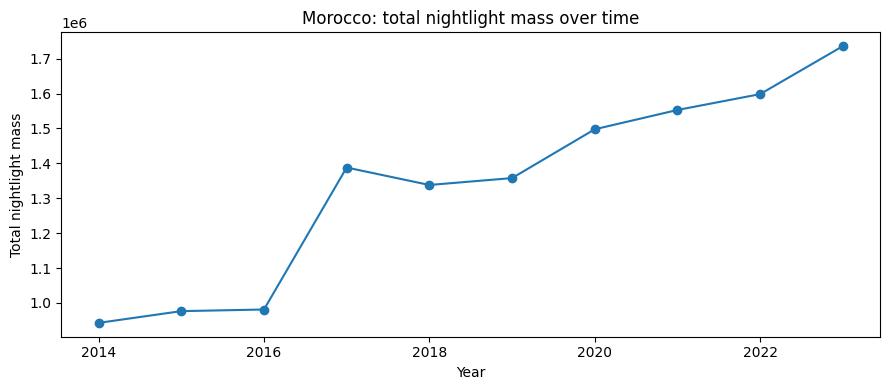

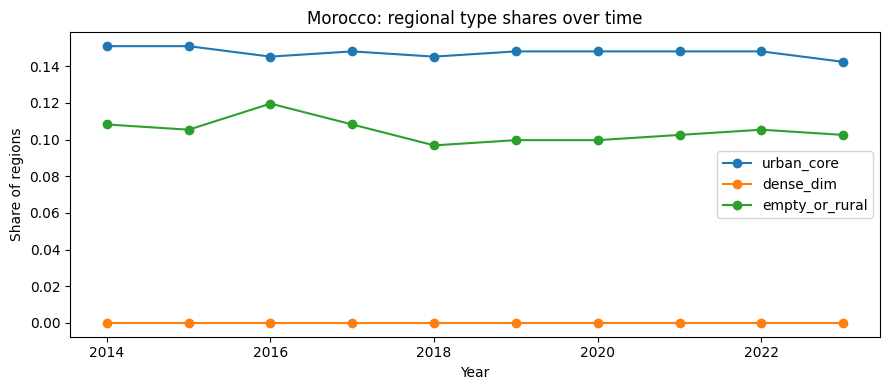

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_total_light_mass_over_time.png
Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_region_type_shares_over_time.png


In [27]:
out_csv = os.path.join(OUTPUT_DIR, "Morocco_features_country_year.csv")
df_features_country_year.to_csv(out_csv, index=False)
print("Saved:", out_csv)

plt.figure(figsize=(9,4))
plt.plot(df_features_country_year["year"], df_features_country_year["total_light_mass"], marker="o")
plt.title("Morocco: total nightlight mass over time")
plt.xlabel("Year")
plt.ylabel("Total nightlight mass")
plt.tight_layout()
p1 = os.path.join(OUTPUT_DIR, "Morocco_total_light_mass_over_time.png")
plt.savefig(p1, dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(9,4))
plt.plot(df_features_country_year["year"], df_features_country_year["region_share_urban_core"], marker="o", label="urban_core")
plt.plot(df_features_country_year["year"], df_features_country_year["region_share_dense_dim"], marker="o", label="dense_dim")
plt.plot(df_features_country_year["year"], df_features_country_year["region_share_empty_or_rural"], marker="o", label="empty_or_rural")
plt.title("Morocco: regional type shares over time")
plt.xlabel("Year")
plt.ylabel("Share of regions")
plt.legend()
plt.tight_layout()
p2 = os.path.join(OUTPUT_DIR, "Morocco_region_type_shares_over_time.png")
plt.savefig(p2, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", p1)
print("Saved:", p2)

In [28]:
country = "Morocco"
grid = 80
lit_p = 90

gdf_by_year = {}

for y in sorted(images[country].keys()):
    df_y, _ = regional_grid_stats(country, y, grid=grid, lit_p=lit_p)
    df_y = add_region_type(df_y)
    gdf_y = regions_to_geodataframe(country, y, df_y, grid=grid)
    gdf_by_year[y] = gdf_y

print("Years with region maps:", list(gdf_by_year.keys()))

Years with region maps: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


Each panel shows the same country divided into fixed spatial regions. Regions are classified by the joint distribution of population density and nightlight intensity. Using the same thresholds each year allows us to visually track how urban cores, under-lit dense regions, and sparsely populated but bright regions evolve over time

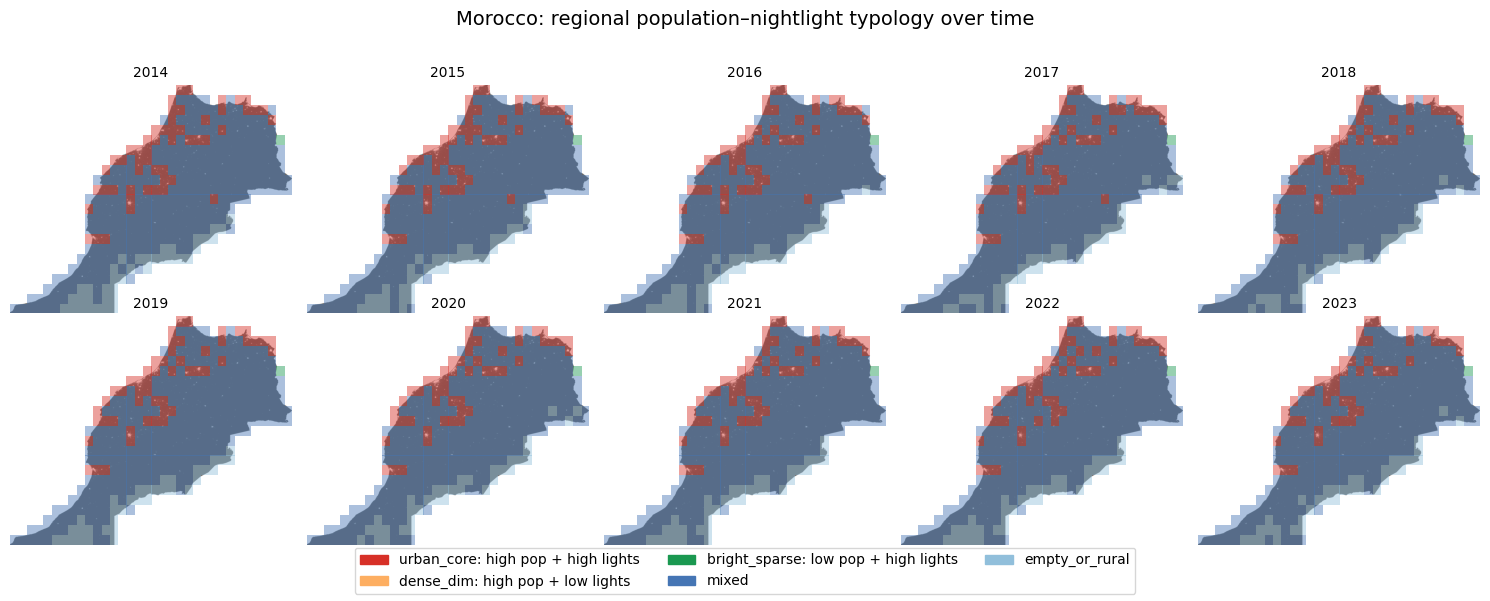

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_region_types_all_years.png


In [29]:
import matplotlib.patches as mpatches
years_to_plot = sorted(gdf_by_year.keys())  # all years
n = len(years_to_plot)

# layout: 2 rows if many years
ncols = 5
nrows = int(np.ceil(n / ncols))

colors = {
    "urban_core": "#d73027",
    "dense_dim": "#fdae61",
    "bright_sparse": "#1a9850",
    "mixed": "#4575b4",
    "empty_or_rural": "#91bfdb"
}

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows), sharex=True, sharey=True)
axes = axes.flatten()

# bounds (same for all years)
with rasterio.open(images[country][years_to_plot[0]]["path"]) as ds:
    left, bottom, right, top = ds.bounds
    extent = (left, right, bottom, top)

for ax, y in zip(axes, years_to_plot):
    gdf = gdf_by_year[y]

    # background nightlights (faint)
    nl = images[country][y]["nightlights"]
    v = nl[np.isfinite(nl)]
    hi = np.percentile(v, 99.7) if v.size else 1
    ax.imshow(np.clip(nl, 0, hi),
              extent=extent, cmap="gray",
              origin="upper", alpha=0.6)

    # overlay regions
    for t, sub in gdf.groupby("region_type"):
        sub.plot(ax=ax, facecolor=colors[t], edgecolor="none", alpha=0.45)

    ax.set_title(str(y), fontsize=10)
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    ax.axis("off")

# turn off unused axes
for ax in axes[len(years_to_plot):]:
    ax.axis("off")

# legend (single, shared)
legend_items = [
    mpatches.Patch(color=colors["urban_core"], label="urban_core: high pop + high lights"),
    mpatches.Patch(color=colors["dense_dim"], label="dense_dim: high pop + low lights"),
    mpatches.Patch(color=colors["bright_sparse"], label="bright_sparse: low pop + high lights"),
    mpatches.Patch(color=colors["mixed"], label="mixed"),
    mpatches.Patch(color=colors["empty_or_rural"], label="empty_or_rural")
]
fig.legend(handles=legend_items, loc="lower center", ncol=3, frameon=True)

fig.suptitle("Morocco: regional population–nightlight typology over time", fontsize=14)
plt.tight_layout(rect=[0,0.05,1,0.95])

out = os.path.join(OUTPUT_DIR, "Morocco_region_types_all_years.png")
plt.savefig(out, dpi=250, bbox_inches="tight")
plt.show()
print("Saved:", out)

In [30]:
# pooled thresholds across all years (stable comparison)
q_pop20 = df_reg_all["mean_pop"].quantile(0.2)
q_pop50 = df_reg_all["mean_pop"].quantile(0.5)
q_pop80 = df_reg_all["mean_pop"].quantile(0.8)

q_nl20  = df_reg_all["mean_nl"].quantile(0.2)
q_nl50  = df_reg_all["mean_nl"].quantile(0.5)
q_nl80  = df_reg_all["mean_nl"].quantile(0.8)

TH = dict(q_pop20=q_pop20, q_pop50=q_pop50, q_pop80=q_pop80,
          q_nl20=q_nl20, q_nl50=q_nl50, q_nl80=q_nl80)

TH

{'q_pop20': np.float64(1.55893988609314),
 'q_pop50': np.float64(18.508655548095703),
 'q_pop80': np.float64(78.43091888427735),
 'q_nl20': np.float64(0.22313769459724428),
 'q_nl50': np.float64(0.35090775787830353),
 'q_nl80': np.float64(0.737967610359192)}

In [31]:
def add_region_type_fixed(df, TH):
    df = df.copy()
    def label(r):
        if r["mean_pop"] < TH["q_pop20"] and r["mean_nl"] < TH["q_nl20"]:
            return "empty_or_rural"
        if r["mean_pop"] > TH["q_pop80"] and r["mean_nl"] > TH["q_nl80"]:
            return "urban_core"
        if r["mean_pop"] > TH["q_pop80"] and r["mean_nl"] < TH["q_nl50"]:
            return "dense_dim"
        if r["mean_pop"] < TH["q_pop50"] and r["mean_nl"] > TH["q_nl80"]:
            return "bright_sparse"
        return "mixed"
    df["region_type"] = df.apply(label, axis=1)
    return df

# rebuild geodataframes per year using fixed thresholds
gdf_by_year_fixed = {}
for y in sorted(images["Morocco"].keys()):
    df_y, _ = regional_grid_stats("Morocco", y, grid=80, lit_p=90)
    df_y = add_region_type_fixed(df_y, TH)
    gdf_by_year_fixed[y] = regions_to_geodataframe("Morocco", y, df_y, grid=80)

print("built:", len(gdf_by_year_fixed), "years")

built: 10 years


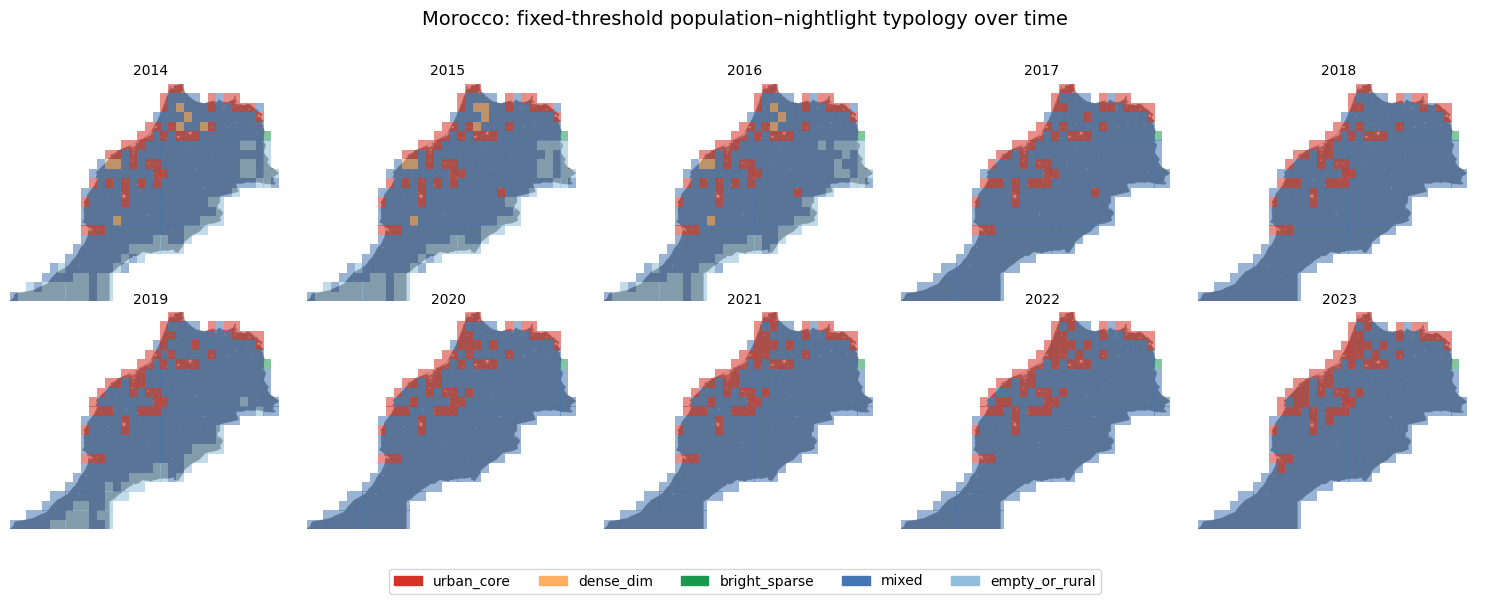

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_region_types_all_years_FIXED.png


In [32]:
import matplotlib.patches as mpatches
years_to_plot = sorted(gdf_by_year_fixed.keys())
ncols = 5
nrows = int(np.ceil(len(years_to_plot) / ncols))

colors = {
    "urban_core": "#d73027",
    "dense_dim": "#fdae61",
    "bright_sparse": "#1a9850",
    "mixed": "#4575b4",
    "empty_or_rural": "#91bfdb"
}

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows), sharex=True, sharey=True)
axes = axes.flatten()

with rasterio.open(images["Morocco"][years_to_plot[0]]["path"]) as ds:
    left, bottom, right, top = ds.bounds
    extent = (left, right, bottom, top)

for ax, y in zip(axes, years_to_plot):
    gdf = gdf_by_year_fixed[y]

    nl = images["Morocco"][y]["nightlights"]
    v = nl[np.isfinite(nl)]
    hi = np.percentile(v, 99.7) if v.size else 1
    ax.imshow(np.clip(nl, 0, hi), extent=extent, cmap="gray", origin="upper", alpha=0.55)

    for t, sub in gdf.groupby("region_type"):
        sub.plot(ax=ax, facecolor=colors[t], edgecolor="none", alpha=0.55)

    ax.set_title(str(y), fontsize=10)
    ax.axis("off")

for ax in axes[len(years_to_plot):]:
    ax.axis("off")

legend_items = [
    mpatches.Patch(color=colors["urban_core"], label="urban_core"),
    mpatches.Patch(color=colors["dense_dim"], label="dense_dim"),
    mpatches.Patch(color=colors["bright_sparse"], label="bright_sparse"),
    mpatches.Patch(color=colors["mixed"], label="mixed"),
    mpatches.Patch(color=colors["empty_or_rural"], label="empty_or_rural")
]
fig.legend(handles=legend_items, loc="lower center", ncol=5, frameon=True)

fig.suptitle("Morocco: fixed-threshold population–nightlight typology over time", fontsize=14)
plt.tight_layout(rect=[0,0.06,1,0.95])

out = os.path.join(OUTPUT_DIR, "Morocco_region_types_all_years_FIXED.png")
plt.savefig(out, dpi=250, bbox_inches="tight")
plt.show()
print("Saved:", out)

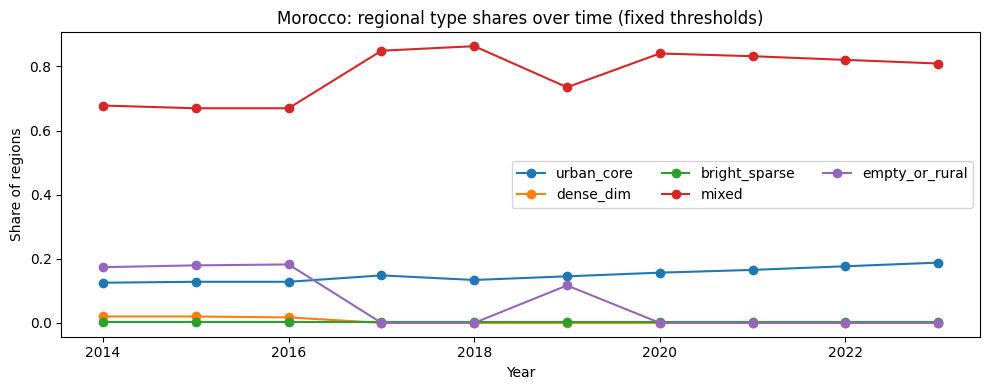

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\week5_outputs\Morocco_region_type_shares_FIXED.png


In [33]:
shares = []
for y, gdf in gdf_by_year_fixed.items():
    s = gdf["region_type"].value_counts(normalize=True)
    shares.append({
        "year": y,
        "urban_core": float(s.get("urban_core", 0)),
        "dense_dim": float(s.get("dense_dim", 0)),
        "bright_sparse": float(s.get("bright_sparse", 0)),
        "mixed": float(s.get("mixed", 0)),
        "empty_or_rural": float(s.get("empty_or_rural", 0)),
    })

df_shares = pd.DataFrame(shares).sort_values("year")

plt.figure(figsize=(10,4))
for col in ["urban_core","dense_dim","bright_sparse","mixed","empty_or_rural"]:
    plt.plot(df_shares["year"], df_shares[col], marker="o", label=col)
plt.title("Morocco: regional type shares over time (fixed thresholds)")
plt.xlabel("Year")
plt.ylabel("Share of regions")
plt.legend(ncol=3)
plt.tight_layout()

out = os.path.join(OUTPUT_DIR, "Morocco_region_type_shares_FIXED.png")
plt.savefig(out, dpi=250, bbox_inches="tight")
plt.show()
print("Saved:", out)